Bagging with Decision Trees: Training

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

rng = np.random.RandomState(seed=4190)
def bagging_fit(X, y, n_estimators, max_depth=5, max_samples=200):
    n_examples = len(y)
    estimators = [DecisionTreeClassifier(max_depth=max_depth) for _ in range(n_estimators)]
    for tree in estimators:
        bag = np.random.choice(n_examples, max_samples, replace=True)
        tree.fit(X[bag, :], y[bag])
    
    return estimators

Bagging with decision trees: prediction

In [2]:
from scipy.stats import mode

def bagging_predict(X, estimators):
    all_predictions = np.array([tree.predict(X) for tree in estimators])
    
    ypred, _ = mode(all_predictions, axis=0, keepdims=False)
    return np.squeeze(ypred)

In [3]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X, y = make_moons(n_samples=300, noise=.25, random_state=rng)
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=.33, random_state=rng)
bag_ens = bagging_fit(Xtrn, ytrn, n_estimators=500, max_depth=12, max_samples=300)
ypred = bagging_predict(Xtst, bag_ens)

print(accuracy_score(ytst, ypred))

0.898989898989899


In [4]:
ensemble_acc = accuracy_score(ytst, ypred)
print(f"Bagging: Holdout accuracy = {ensemble_acc*100:4.2f}%")
tree = DecisionTreeClassifier(max_depth=12)
ypred_single = tree.fit(Xtrn, ytrn).predict(Xtst)
tree_acc = accuracy_score(ytst, ypred_single)
print("Single Decision Tree: Holdout test accuracy = {0:4.2f}%".format(tree_acc * 100))

Bagging: Holdout accuracy = 89.90%
Single Decision Tree: Holdout test accuracy = 83.84%


In [5]:
from plot_utils import plot_2d_data, plot_2d_classifier
import matplotlib.pyplot as plt

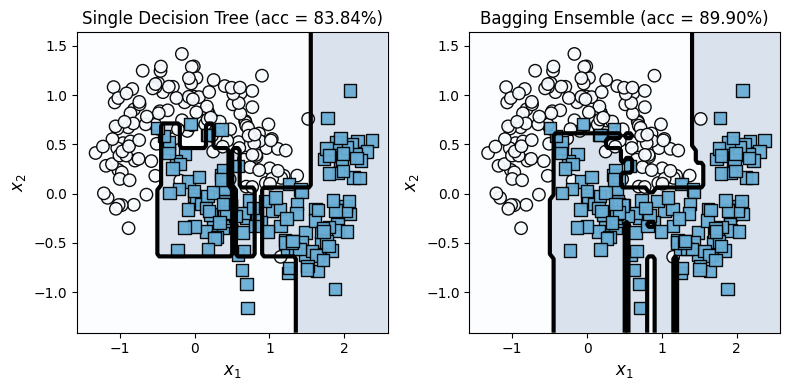

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
title = "Single Decision Tree (acc = {0:4.2f}%)".format(tree_acc * 100)
plot_2d_classifier(ax[0], X, y, tree.predict, 
                   alpha=.15, s=80,
                   xlabel='$x_1$', ylabel='$x_2$', title=title, colormap='Blues')

title = "Bagging Ensemble (acc = {0:4.2f}%)".format(ensemble_acc * 100)
plot_2d_classifier(ax[1], X, y, bagging_predict, predict_args=(bag_ens), 
                   alpha=.15, s=80,
                   xlabel='$x_1$', ylabel='$x_2$', title=title, colormap='Blues')

fig.tight_layout()

### Bagging with `scikit-learn`

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

base_estimator = DecisionTreeClassifier(max_depth=10)
bag_ens = BaggingClassifier(estimator=base_estimator, n_estimators=500, max_samples=100, oob_score=True, random_state=rng)
bag_ens.fit(Xtrn, ytrn)
ypred = bag_ens.predict(Xtst)

In [8]:
bag_ens.oob_score_

0.9402985074626866

In [9]:
accuracy_score(ytst, ypred)

0.9292929292929293

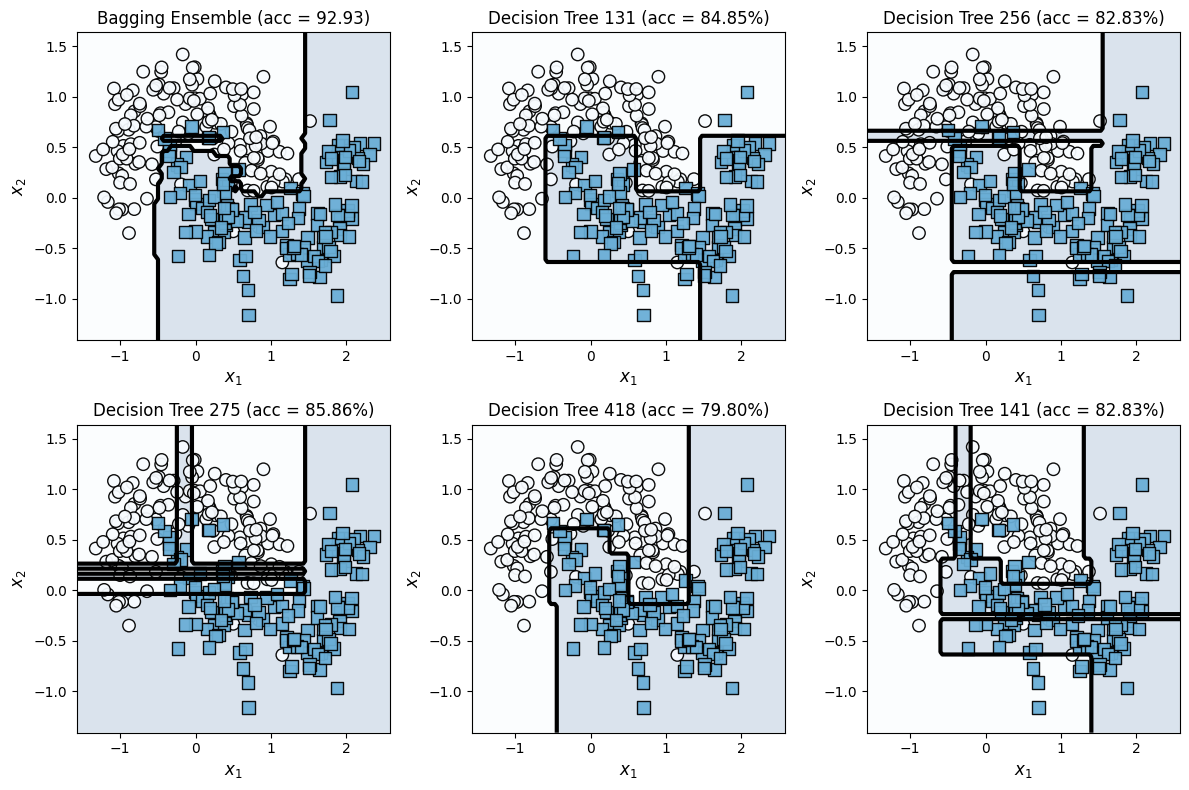

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
trees_to_plot = np.random.choice(500, 5, replace=True)

title = "Bagging Ensemble (acc = {0:4.2f})".format(accuracy_score(ytst, ypred) * 100)
plot_2d_classifier(ax[0, 0], X, y, colormap='Blues', alpha=0.15, s=80, predict_function=bag_ens.predict, xlabel='$x_1$', ylabel='$x_2$', title=title)
for i in range(5):
    r, c = np.divmod(i + 1, 3)
    j = trees_to_plot[i]
    tst_acc_clf = accuracy_score(ytst, bag_ens[i].predict(Xtst))
    
    bag = bag_ens.estimators_samples_[j]
    X_bag = X[bag, :]
    y_bag = y[bag]
    
    title = "Decision Tree {1} (acc = {0:4.2f}%)".format(tst_acc_clf * 100, j+1)
    plot_2d_classifier(ax[r, c], X, y, colormap='Blues', alpha=.15, s=80, predict_function=bag_ens[j].predict,
                       xlabel='$x_1$', ylabel='$x_2$', title=title)
    
fig.tight_layout()

### 2.2.4	Faster Training with Parallelization

In [11]:
import time
import os
import pickle

if not os.path.exists("./data/SequentialVsParallelBagging.pickle"):
    n_estimator_range = np.arange(50, 525, 50, dtype=int)
    n_range = len(n_estimator_range)
    n_runs = 10
    
    run_time_seq = np.zeros((n_runs, n_range))
    run_time_par = np.zeros((n_runs, n_range))
    
    base_estimator = DecisionTreeClassifier(max_depth=5)
    for r in range(n_runs):
        X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=100)
        
        for i, n_estimators in enumerate(n_estimator_range):
            start = time.time()
            bag_ens = BaggingClassifier(estimator=base_estimator,
                                        n_estimators=n_estimators,
                                        max_samples=100, oob_score=True, n_jobs=1)
            bag_ens.fit(X_trn, y_trn)
            run_time_seq[r, i] = time.time() - start
            
        for i, n_estimators in enumerate(n_estimator_range):
            start = time.time()
            bag_ens = BaggingClassifier(estimator=base_estimator,
                                        n_estimators=n_estimators,
                                        max_samples=100, oob_score=True, n_jobs=-1)
            bag_ens.fit(X_trn, y_trn)
            run_time_par[r, i] = time.time() - start
    
    results = (run_time_seq, run_time_par)
    
    with open('./data/SequentialVsParallelBagging.pickle', 'wb') as result_file:
        pickle.dump(results, result_file)
    
else:
    with open('./data/SequentialVsParallelBagging.pickle', 'rb') as result_file:
        (run_time_seq, run_time_par) = pickle.load(result_file)

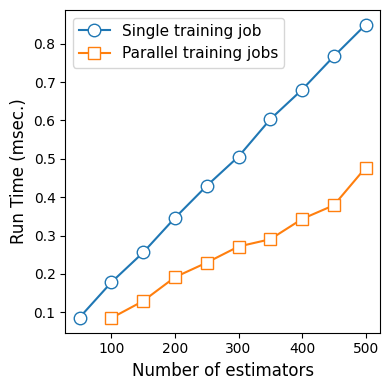

In [12]:
n_estimator_range = np.arange(50, 525, 50, dtype=int)
run_time_seq_adj = np.copy(run_time_seq)
# run_time_seq_adj[run_time_seq > 0.5] = np.nan
run_time_seq_mean = np.nanmean(run_time_seq_adj, axis=0)

run_time_par_adj = np.copy(run_time_par)
# run_time_par_adj[run_time_par > .3] = np.nan
run_time_par_mean = np.nanmean(run_time_par_adj, axis=0)

fig = plt.figure(figsize=(4, 4))

plt.plot(n_estimator_range, run_time_seq_mean, linewidth=1.5, marker='o', markersize=9, mfc='w')
plt.plot(n_estimator_range[1:], run_time_par_mean[1:], linewidth=1.5, 
         marker='s', markersize=9, mfc='w')
plt.ylabel("Run Time (msec.)", fontsize=12)
plt.xlabel("Number of estimators", fontsize=12)
plt.legend(['Single training job', 'Parallel training jobs'], fontsize=11, loc='upper left')
fig.tight_layout()

## Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf_ens = RandomForestClassifier(n_estimators=500, max_depth=10, oob_score=True, n_jobs=-1,
                                random_state=rng)

rf_ens.fit(Xtrn, ytrn)
ypred = rf_ens.predict(Xtst)

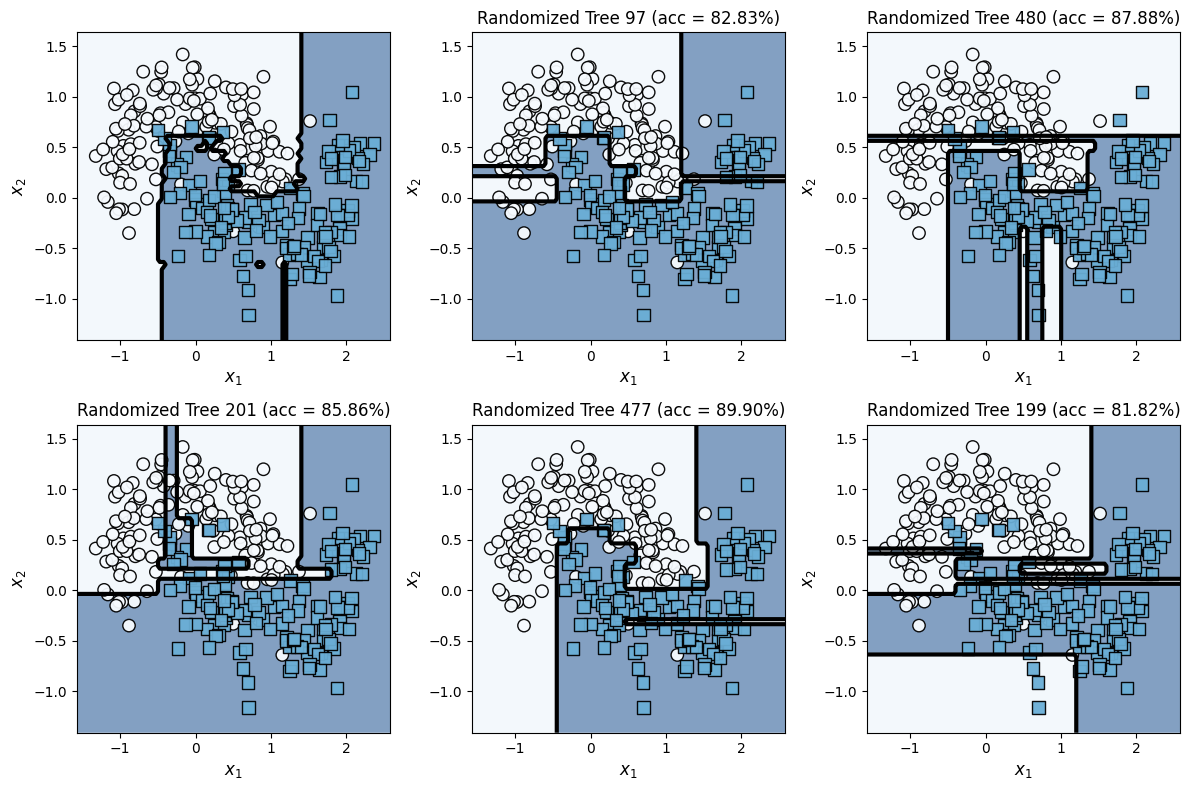

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
tree_to_plot = np.random.choice(500, 5, replace=True)

title = "Random Forest (acc = {0:4.2f}%)".format(accuracy_score(ytst, ypred) * 100)
plot_2d_classifier(ax[0, 0], X, y, colormap='Blues', alpha=.5, s=80, predict_function=rf_ens.predict,
                   xlabel="$x_1$", ylabel='$x_2$')

for i in range(5):
    r, c = np.divmod(i + 1, 3)
    j = tree_to_plot[i]
    
    tst_acc_clf = accuracy_score(ytst, rf_ens[j].predict(Xtst))
    
    title = "Randomized Tree {1} (acc = {0:4.2f}%)".format(tst_acc_clf * 100, j + 1)
    plot_2d_classifier(ax[r, c], X, y, colormap='Blues', alpha=.5, s=80,
                       predict_function=rf_ens[j].predict, xlabel='$x_1$', ylabel='$x_2$',
                       title=title)

fig.tight_layout()

In [15]:
for i, score in enumerate(rf_ens.feature_importances_):
    print("Feature x{0}: {1:6.5f}".format(i, score))

Feature x0: 0.50072
Feature x1: 0.49928


In [17]:
from sklearn.svm import SVC

In [20]:
bag_ens = BaggingClassifier(
    estimator=SVC(), n_estimators=100, max_samples=1.0, bootstrap=False,
    max_features=.5, bootstrap_features=True # random subspaces
)

In [21]:
bag_ens = BaggingClassifier(
    estimator=SVC(), n_estimators=100, 
    max_samples=.75, bootstrap=True,
    max_features=.5, bootstrap_features=True # random patches
)

In [22]:
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier